# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 12: Building and Regularizing your first Neural Network 

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras.  <br>
**Authors:** Eleni Kaxiras, David Sondak, and Pavlos Protopapas. 

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
%matplotlib inline

from PIL import Image, ImageOps

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print(tf.__version__)  # You should see a 2.0.0 here!

2.0.0


#### Picking up where we left off `tf.keras` with Tensorflow 2.0:  

```              
tf.keras.models.Sequential
tf.keras.layers.Dense, tf.keras.layers.Activation, 
tf.keras.layers.Dropout, tf.keras.layers.Flatten, tf.keras.layers.Reshape
tf.keras.optimizers.SGD
tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.regularizers
tf.keras.datasets.mnist   
```

## Learning Goals
In this lab we will continue with the basics of feedforward neural networks, we will create one and explore various ways to optimize and regularize it using `tf.keras`, a deep learning library inside the broader framework called [Tensorflow](https://www.tensorflow.org). By the end of this lab, you should:

- Understand how a simple neural network works and code some of its functionality using `tf.keras`.
- Think of vectors and arrays as tensors. Learn how to do basic image manipulations.
- Implement a simple real world example using a neural network. Find ways to improve its performance.

## Part 1: Motivation

<div class="exercise"><b>In class discussion : why do we care about Neural Nets?</b></div>

**Buzzwords**: Linearity, Interpretability, Performance

## Part 2: Data Preparation

### Tensors

We can think of tensors as multidimensional arrays of real numerical values; their job is to generalize matrices to multiple dimensions. 

- **scalar** = just a number = rank 0 tensor  ($a$ ∈ $F$,)
<BR><BR>
    
- **vector** = 1D array = rank 1 tensor ( $x = (\;x_1,...,x_i\;)⊤$ ∈ $F^n$ )
<BR><BR>
    
- **matrix** = 2D array = rank 2 tensor ( $\textbf{X} = [a_{ij}] ∈ F^{m×n}$ )
<BR><BR>
    
- **3D array** = rank 3 tensor ( $\mathscr{X} =[t_{i,j,k}]∈F^{m×n×l}$ )
<BR><BR>
    
- **$\mathscr{N}$D array** = rank $\mathscr{N}$ tensor ( $\mathscr{T} =[t_{i1},...,t_{i\mathscr{N}}]∈F^{n_1×...×n_\mathscr{N}}$ ) <-- **Things start to get complicated here...**
    
#### Tensor indexing
We can create subarrays by fixing some of the given tensor’s indices. We can create a vector by fixing all but one index. A 2D matrix is created when fixing all but two indices. For example, for a third order tensor the vectors are
<br><BR>
$\mathscr{X}[:,j,k]$ = $\mathscr{X}[j,k]$ (column), <br>
$\mathscr{X}[i,:,k]$ = $\mathscr{X}[i,k]$ (row), and <BR>
$\mathscr{X}[i,j,:]$ = $\mathscr{X}[i,j]$ (tube) <BR>
 
#### Tensor multiplication
We can multiply one matrix with another as long as the sizes are compatible ((n × m) × (m × p) = n × p), and also multiply an entire matrix by a constant. Numpy `numpy.dot` performs a matrix multiplication which is straightforward when we have 2D or 1D arrays. But what about > 3D arrays? The function will choose according to the matching dimentions but if we want to choose we should use `tensordot`, but, again, we **do not need tensordot** for this class. 

### Reese Witherspoon as a Rank 3 Tensor

A common kind of data input to a neural network is images. Images are nice to look at, but remember, the computer only sees a series of numbers arranged in `tensors`. In this part we will look at how images are displayed and altered in Python. 

`matplotlib` supports only .png images but uses a library called `Pillow` to handle any image. If you do not have `Pillow` installed you can do this in anaconda:
```
conda install -c anaconda pillow 

OR 

pip install pillow
```

This image is from the dataset [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/person/Reese_Witherspoon.html) used for machine learning training. Images are 24-bit RGB images (height, width, channels) with 8 bits for each of R, G, B channel. Explore and print the array.

The image is a: <class 'numpy.ndarray'> of shape (150, 150, 3)


array([[[241, 241, 241],
        [242, 242, 242]],

       [[241, 241, 241],
        [242, 242, 242]]], dtype=uint8)

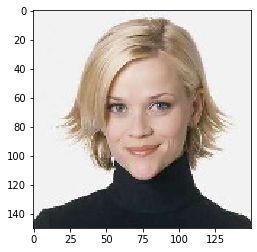

In [4]:
import matplotlib.image as mpimg

# load and show the image
FILE = '../fig/Reese_Witherspoon.jpg'
img = mpimg.imread(FILE);
imgplot = plt.imshow(img);

print(f'The image is a: {type(img)} of shape {img.shape}')
img[3:5, 3:5, :]

#### Slicing tensors: slice along each axis

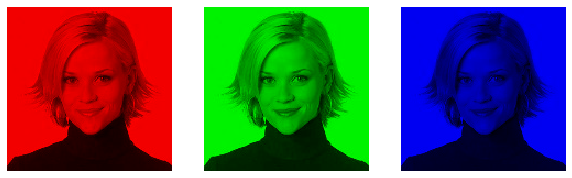

In [5]:
# we want to show each color channel
fig, axes = plt.subplots(1, 3, figsize=(10,10))
for i, subplot in zip(range(3), axes):
    temp = np.zeros(img.shape, dtype='uint8')
    temp[:,:,i] = img[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

#### Multiplying Images with a scalar

Just for fun, no real use for this lab!

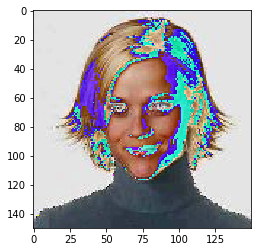

In [6]:
temp = img
temp = temp * 2
plt.imshow(temp)

For more on image manipulation by `matplotlib` see: [matplotlib-images](https://matplotlib.org/3.1.1/tutorials/introductory/images.html)

## Part 3: Building an Artificial Neural Network

https://www.tensorflow.org/guide/keras

`tf.keras` is TensorFlow's high-level API for building and training deep learning models. It's used for fast prototyping, state-of-the-art research, and production. `Keras` is a library created by François Chollet. After Google released Tensorflow 2.0, the creators of `keras` recommend that "Keras users who use multi-backend Keras with the TensorFlow backend switch to `tf.keras` in TensorFlow 2.0. `tf.keras` is better maintained and has better integration with TensorFlow features".

NOTE:  In `Keras` everything starts with a Tensor of N samples as input and ends with a Tensor of N samples as output.

### First you build it ...

Parts of a NN:

* Part 1: the input layer (our dataset)

* Part 2: the internal architecture or hidden layers (the number of layers, the activation functions, the learnable parameters and other hyperparameters)
* Part 3: the output layer (what we want from the network - classification or regression)

### ... and then you train it!

1. Load and pre-process the data
2. Define the layers of the model.
3. Compile the model.
4. Fit the model to the train set (also using a validation set).
5. Evaluate the model on the test set.
6. We learn a lot by studying History! Plot metrics such as accuracy.
7. Now let's use the Network for what it was meant to do: Predict on the test set!
8. Try our model on a sandal from the Kanye West collection!

In [7]:
# set the seed for reproducability of results
seed = 7
np.random.seed(seed)

### Fashion MNIST 

**Fashion-MNIST** is a dataset of clothing article images (created by [Zalando](https://github.com/zalandoresearch/fashion-mnist)), consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a **28 x 28** grayscale image, associated with a label from **10 classes**. The creators intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Each pixel is 8 bits so its value ranges from 0 to 255.

Let's load and look at it!

#### 1. Load and pre-process the data

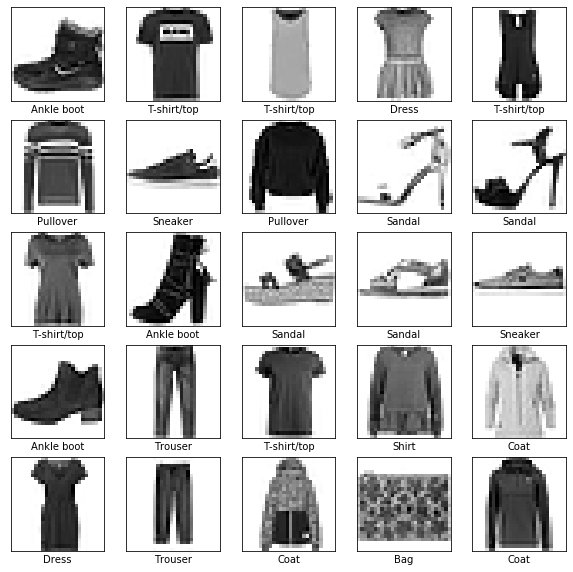

In [8]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data splitted in train and test! how nice!
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
x_train, x_test = x_train / 255.0, x_test / 255.0

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

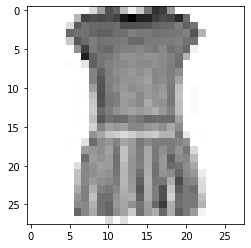

In [9]:
# choose one image to look at
plt.imshow(x_train[3], cmap=plt.cm.binary)

In [10]:
# take a look at the array shapes
x_train.shape, x_test.shape, y_train.shape

((60000, 28, 28), (10000, 28, 28), (60000,))

#### 2. Define the layers of the model.

In [11]:
# type your code here along with instructor


In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(154, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

#### 3. Compile the model

In [13]:
# type your code here along with instructor


In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [15]:
# print a summary of your model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 154)               120890    
_________________________________________________________________
dropout (Dropout)            (None, 154)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                9920      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 131,460
Trainable params: 131,460
Non-trainable params: 0
__________________________________________________

In [16]:
# use this cool `tf.keras` method to visualize the layers of your network
tf.keras.utils.plot_model(
    model,
    #to_file='model.png', # if you want to save the image
    show_shapes=True, # True for more details than you need
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


[Everything you wanted to know about a Keras Model and were afraid to ask](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

#### 4. Fit the model to the train set (also using a validation set)

This is the part that takes the longest in terms of time and where having GPUs helps.

-----------------------------------------------------------
**ep·och** <BR>
noun: epoch; plural noun: epochs. A period of time in history or a person's life, typically one marked by notable events or particular characteristics. Examples: "the Victorian epoch", "my Neural Netwok's epochs". <BR>
    
-----------------------------------------------------------

In [17]:
# type your code here along with instructor


In [18]:
%%time
# the core of the network training
history = model.fit(x_train, y_train, validation_split=0.33, epochs=50, 
                    verbose=2)

Train on 40199 samples, validate on 19801 samples
Epoch 1/50
40199/40199 - 3s - loss: 0.6980 - accuracy: 0.7520 - val_loss: 0.4499 - val_accuracy: 0.8349
Epoch 2/50
40199/40199 - 2s - loss: 0.4885 - accuracy: 0.8273 - val_loss: 0.4028 - val_accuracy: 0.8517
Epoch 3/50
40199/40199 - 2s - loss: 0.4471 - accuracy: 0.8377 - val_loss: 0.3764 - val_accuracy: 0.8629
Epoch 4/50
40199/40199 - 2s - loss: 0.4156 - accuracy: 0.8512 - val_loss: 0.3877 - val_accuracy: 0.8580
Epoch 5/50
40199/40199 - 2s - loss: 0.4007 - accuracy: 0.8556 - val_loss: 0.3630 - val_accuracy: 0.8700
Epoch 6/50
40199/40199 - 2s - loss: 0.3852 - accuracy: 0.8599 - val_loss: 0.3533 - val_accuracy: 0.8731
Epoch 7/50
40199/40199 - 2s - loss: 0.3745 - accuracy: 0.8635 - val_loss: 0.3461 - val_accuracy: 0.8741
Epoch 8/50
40199/40199 - 2s - loss: 0.3649 - accuracy: 0.8654 - val_loss: 0.3433 - val_accuracy: 0.8765
Epoch 9/50
40199/40199 - 2s - loss: 0.3559 - accuracy: 0.8701 - val_loss: 0.3409 - val_accuracy: 0.8750
Epoch 10/50
40

#### Save the model

You can save the model so you do not have `.fit` everytime you reset the kernel in the notebook. Network training is expensive!

For more details on this see [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [19]:
# save the model so you do not have to run the code everytime
model.save('fashion_model.h5')

# Recreate the exact same model purely from the file
#model = tf.keras.models.load_model('fashion_model.h5')

#### 5. Evaluate the model on the test set.

In [20]:
# type your code here along with instructor


In [21]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy={test_accuracy:.4f}')
if test_accuracy>0.8: print(f'Not bad!')

Test accuracy=0.8849
Not bad!


#### 6. We learn a lot by studying History! Plot metrics such as accuracy. 

You can learn a lot about neural networks by observing how they perform while training. You can issue `kallbacks` in `keras`. The networks's performance is stored in a `keras` callback aptly named `history` which can be plotted. 

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


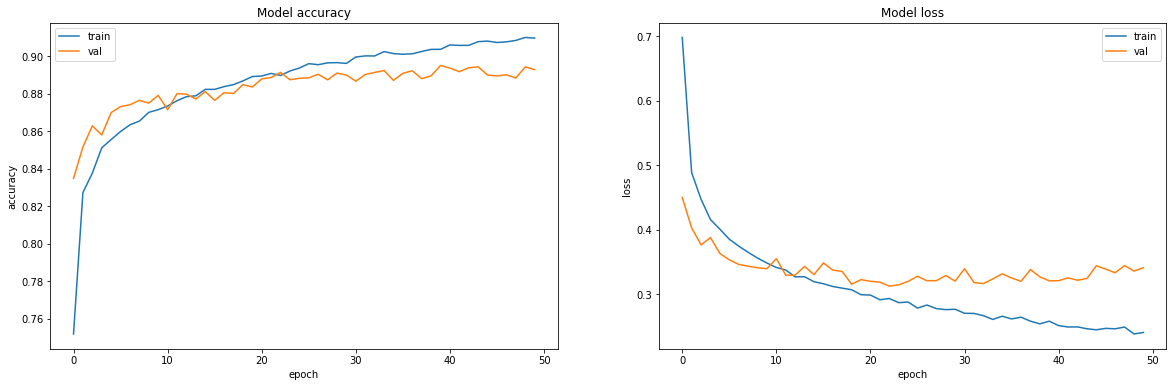

In [23]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

We notice that the model starts to overfil after ~10 epochs.

#### 7. Now let's use the Network for what it was meant to do: Predict on the test set!

In [24]:
# type your code here along with instructor


In [25]:
predictions = model.predict(x_test)
print(f'These are the Network\'s predicted probabilities for each class for the first test image: \n{predictions[0]}')
print(f'Our Oracle says this is a class {np.argmax(predictions[0]):.2f}, which is a {class_names[np.argmax(predictions[0])]}')

These are the Network's predicted probabilities for each class for the first test image: 
[6.6348205e-11 4.2307529e-12 3.7758525e-11 2.4526889e-09 3.1851086e-12
 8.1893377e-06 1.3119787e-09 1.1094623e-03 7.3352539e-12 9.9888235e-01]
Our Oracle says this is a class 9.00, which is a Ankle boot


Let's see if our network predicted right! Does this item really look like what was predicted?

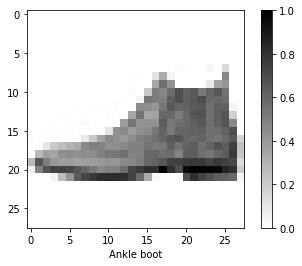

In [26]:
plt.figure()
plt.imshow(x_test[0], cmap=plt.cm.binary)
plt.xlabel(class_names[y_test[0]])
plt.colorbar()

Now let's see how confident our model is by plotting the probability values:

In [27]:
# code source: https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

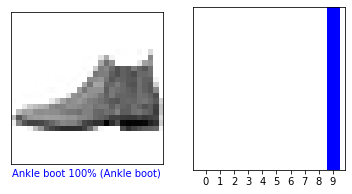

In [28]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

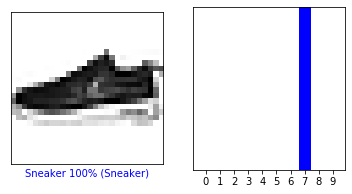

In [29]:
i = 38
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

The model is very confident! It predicts and ankle boot with 100% probability. 

#### 8. Try our model on a sandal from the Kanye West collection!
Let's see if our network can generalize beyond the MNIST fashion dataset. Let's give it a trendy shoe and see what it predicts. Here is the image:

<img src="../fig/kanye_shoe.jpg" alt="shoe" width="150" height="150"><BR>
<div class="exercise"><b>In class discussion : What kinds of images can our model predict?</b></div>

**Buzzword**: Generalization



In [30]:
# Let'see the tensor shape
shoe = np.array(Image.open('../fig/kanye_28.jpg'))
shoe.shape

(28, 28, 3)

In [31]:
# We need to delete the other 2 channels and make the image B&W. 
shoe = shoe[:,:,0]
shoe.shape

(28, 28)

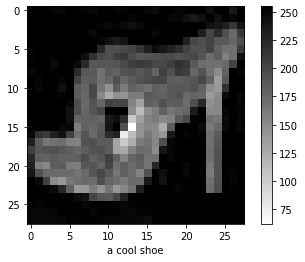

In [32]:
plt.figure()
plt.imshow(shoe, cmap=plt.cm.binary)
plt.xlabel('a cool shoe')
plt.colorbar()

`tf.keras` models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [33]:
# Add the image to a batch where it's the only member.
shoe_batch = (np.expand_dims(shoe,0))
print(shoe_batch.shape)

(1, 28, 28)


In [34]:
predictions_single = model.predict(shoe_batch)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8 Bag


That was not classified right! Maybe it's because the colors are not the ones that the network is expecting. All images in our training set had a white background. Let's change it and see if we fair better.

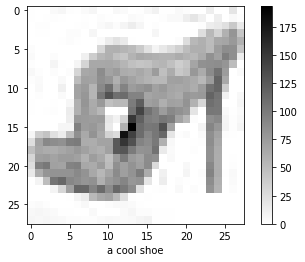

In [35]:
shoe = np.ones(shoe.shape) * 255 - shoe
plt.figure()
plt.imshow(shoe, cmap=plt.cm.binary)
plt.xlabel('a cool shoe')
plt.colorbar()

Let's try our model with this changed shoe

In [36]:
# Add the image to a batch where it's the only member.
shoe_batch = (np.expand_dims(shoe,0))
print(shoe_batch.shape)

(1, 28, 28)


In [37]:
predictions_single = model.predict(shoe_batch)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9 Ankle boot


Well, not exactly, but good enough, the best would be sandal; one student got that in her prediction.

<div class="exercise"><b>In class discussion : How did our model perform?</b></div>
    
**Buzzword:** Convolutional Neural Networks!

Let's now try a different boot:

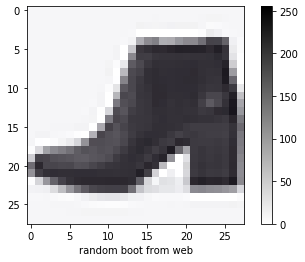

In [38]:
boot = np.array(Image.open('../fig/random_boot.png'))
plt.figure()
plt.imshow(boot, cmap=plt.cm.binary)
plt.xlabel('random boot from web')
plt.colorbar()

In [39]:
# make into one channel
boot = boot[:,:,0]
boot.shape

(28, 28)

In [40]:
boots = (np.expand_dims(boot,0))
print(boot.shape)

(28, 28)


In [41]:
predictions_single = model.predict(boots)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.5638966e-08 0.0000000e+00 1.0000000e+00]
9 Ankle boot


In [42]:
# if it's either a sneaker or a boot we are good
if np.argmax(predictions_single[0]) in [7,9]: print(f'We did better this time!')

We did better this time!


### Regularization
Let's try adding a regularizer in our model. For more see `tf.keras` [regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers).<BR>

1. Norm penalties: `kernel_regularizer= tf.keras.regularizers.l2(l=0.1)`
2. Early stopping via `tf.keras.callbacks`. Callbacks provide a way to interact with the model while it's training and inforce some decisions automatically. Callbacks need to be instantiated and are added to the `.fit()` function via the `callbacks` argument.
3. Dropout

In [ ]:
# callbacks
# watch validation loss and be "patient" for 50 epochs of no improvement
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

model_regular = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(154, activation='relu', 
                        kernel_regularizer= tf.keras.regularizers.l2(l=0.1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64, activation='relu', 
                       kernel_regularizer= tf.keras.regularizers.l2(l=0.1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation='softmax')
])

# compile
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model_regular.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
# fit
history_regular = model_regular.fit(x_train, y_train, validation_split=0.33, epochs=50, 
                    verbose=2) #, callbacks=[es])
                    

Train on 40199 samples, validate on 19801 samples
Epoch 1/50
40199/40199 - 4s - loss: 2.6120 - accuracy: 0.7165 - val_loss: 1.2065 - val_accuracy: 0.6724
Epoch 2/50
40199/40199 - 3s - loss: 1.0802 - accuracy: 0.7239 - val_loss: 1.2412 - val_accuracy: 0.6542
Epoch 3/50
40199/40199 - 3s - loss: 1.0441 - accuracy: 0.7347 - val_loss: 1.0781 - val_accuracy: 0.7227
Epoch 4/50
40199/40199 - 3s - loss: 1.0066 - accuracy: 0.7396 - val_loss: 0.9766 - val_accuracy: 0.7518
Epoch 5/50
40199/40199 - 4s - loss: 1.0031 - accuracy: 0.7396 - val_loss: 1.1661 - val_accuracy: 0.6748
Epoch 6/50
40199/40199 - 3s - loss: 0.9832 - accuracy: 0.7447 - val_loss: 1.0443 - val_accuracy: 0.7188
Epoch 7/50
40199/40199 - 3s - loss: 0.9985 - accuracy: 0.7373 - val_loss: 0.9790 - val_accuracy: 0.7608
Epoch 8/50
40199/40199 - 3s - loss: 0.9866 - accuracy: 0.7438 - val_loss: 1.4033 - val_accuracy: 0.6162
Epoch 9/50
40199/40199 - 3s - loss: 0.9923 - accuracy: 0.7397 - val_loss: 1.0094 - val_accuracy: 0.7281
Epoch 10/50
40

In [ ]:
test_loss, test_accuracy = model_regular.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy for regularized model={test_accuracy}')

In [ ]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history_regular.history['accuracy'])
ax[0].plot(history_regular.history['val_accuracy'])
ax[0].set_title('Regularized Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history_regular.history['loss'])
ax[1].plot(history_regular.history['val_loss'])
ax[1].set_title('Regularized Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

#### Conclusion

We notice that Dropout helped our first model achive a 0.88 accuracy. In our second model which also used L2 regularization, we get a lower accuracy. There is no simple recipe for regularizing neural nets. They are all different.  Different are also the tasks that each is called to solve.